## Introduction

This notebook shows you how to train a SOM on one band with training on every single light curve in the band for a specified number of epochs each. This method proceeds fast as it trains on a random sample of the light curves set for as many epochs as specified. 

### Import Statement

In [1]:
from Clustering_with_SOM import *

In [2]:
#Defining a random seed in numpy for reproducibility
random_seed = 10
np.random.seed(random_seed)

### Preprocessing

It is recommended to create a dictionary for all the filters as shown here to ease use

In [3]:
#Define a dictionary for the filters
Filters = {'u':0,'g':1,'r':2,'i':3,'z':4}

#### Note: Please save the files under a folder (that you can load from here) and also save each filter as a subfolder under that folder. Then, save each light curve under its corresponding the filter folder with the id as its name and in .csv form. 

For example, you can save them under a folder called Light_Curves with the filters u,g,r,i and z as the subfolders. Then, if you want to get the light curve with id 102339 under filter g, it will be in the path 'Light_Curves/g/102339.csv'

In [4]:
#Load the light curves and ids
light_curves,ids = Load_Light_Curves('Light_Curves','ugriz')

Loading z curves: 100%|█████████████████████████████████████████████████████████████| 984/984 [00:01<00:00, 664.47it/s]


In [5]:
#Interactive plot of the light curve
Plot_Lc(light_curves[0][0],x_axis = 'mjd',save_fig=True)

In [6]:
#Padding the light curves to the length of the longest one (over all filters)
#In this case, the padding is done on the first filter (u)
padded_curves = Pad_Light_Curves(light_curves,[0],100)

Padding Light Curves: 984it [00:01, 908.76it/s] 


In [7]:
#Scaling the curves
#Note that you should use the element of the padding curves that corresponds to the filter you padded
scaled_curves,scaled_times = scale_curves(padded_curves[0])

Scaling Times: 100%|████████████████████████████████████████████████████████████████| 984/984 [00:02<00:00, 451.82it/s]


### Training SOM

A brief description of hyperparameters for the SOM will be provided here:

som_x, som_y: The grid size of the SOM. If none are chosen, it defaults to a grid the sqrt of the data (For e.g, if there are 625 points, it defaults to a 5$\times$5 grid). This was chosen to keep the number of nodes low. However, a rule of thumb with SOMs is to choose 5 times that value (In our previous example that would be a grid that is $5\sqrt{625}$ nodes wide, which is roughly a 11$\times$11 grid. You can also choose values that are non-symmetric as per your taste

learning_rate: The impact that each additional data points affects the updating of the weights of the SOM. Lowering the learning rate is showed to decrease the number of obtained clusters and vice-versa. It is an important hyperparameter to tune as per your data.

sigma: The influence that each node has on each of the others. As with the learning_rate, the lower the sigma, the lower the number of resulting clusters. It is also a very important hyperparameter to tune. 

topology: Can choose rectangle or hexagonal. It is recommended to keep it in rectangular for better interpretation of the results.

pca_init: Whether to initialize weights with pca instead of random weights. Has not been shown to affect the SOM too much other than in the very beginning.

neighborhood_function: Can be customized between a range of options and is defined by sigma.

epochs: Under the random train mode, it corresponds to how many randomly chosen samples (with repetition allowed) from the given light curve that the SOM trains on

In [8]:
#Actual Training of the SOM 
som_model,q_error,t_error,indices_to_plot = SOM_1D(scaled_curves,pca_init=False,save_som=False,train_mode='random',epochs=10000,\
                                                   plot_frequency=1000,batch_size = 1,random_seed=random_seed)

Evaluating SOM: 100%|█████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 11203.35it/s]


### Getting Clusters

In [9]:
#Making a proper cluster map
cluster_map = Assign_Cluster_Labels(som_model,scaled_curves,ids)

Creating Dataframe: 100%|█████████████████████████████████████████████████████████| 984/984 [00:00<00:00, 40988.31it/s]


The gradient cluster map is an optional step that can allow you to get larger clusters by grouping together similar nodes. See https://homepage.cs.uri.edu/faculty/hamel/pubs/improved-umat-dmin11.pdf for more details

In [10]:
#Making the cluster map with gradient based clustering
gradient_cluster_map = Gradient_Cluster_Map(som_model,scaled_curves,ids)

### Clustering Metrics

There are 3 clustering metrics of interest that do not depend on the true lables of the data. They are:

1) Silhoutte - Silhoutte Score - Indicates the intracluster distance as related to the intercluster distance. Values close to 1 indicate well clustered data, values close to 0 indicate overlapping clusters (which are common with large SOMs) and values closer to -1 indicate that samples are closer to other clusters instead of their own (See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

2) DBI - Davies Bouldin Index - Similarly to the Silhoutte Score, the DBI measures the similarity of intracluster data vs the similarity between different clusters. It cannot be negative. The closer to 0 it is, the better. (See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.htm) 

3) CH - Calinski and Harabasz Index - Compares the intracluster variance with the variance between different clusters. The higher that it is, the more well seperated the clusters are. (See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html)

These metrics are recommended to be used to test different SOM architectures to find the one that works best with your data1

In [11]:
#Silhoutte Score
print(Cluster_Metrics(scaled_curves,cluster_map,'Silhoutte'))

0.018712038369848003


In [12]:
#Davies-Boudin Index
print(Cluster_Metrics(scaled_curves,cluster_map,'DBI'))

3.5372637733159356


In [13]:
#Calinski-Harabasz score
print(Cluster_Metrics(scaled_curves,cluster_map,'CH'))

22.509796712422045


### SOM Visualization

Note that these plots are saved into a folder called Plots in the subdirectory you specify

In [14]:
#Plotting the Average, Weight and Background curves for each of the nodes
Plot_SOM_Scaled_Average(som_model,scaled_curves,dba = True,plot_avg=True,plot_weights=True,plot_background = True,figsize = (5,5),one_fig=False,show_fig=False)

Creating Plots: 100%|████████████████████████████████████████████████████████████████████| 6/6 [00:21<00:00,  3.53s/it]


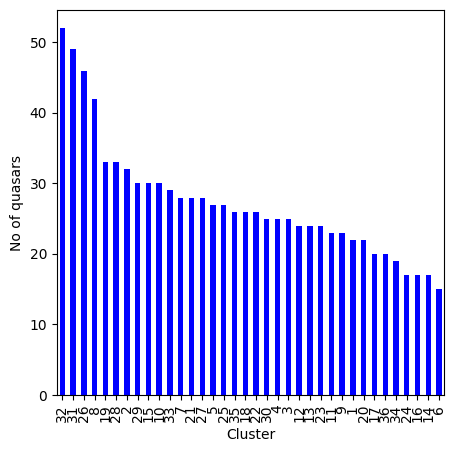

In [15]:
#The number of quasars per cluster
SOM_Clusters_Histogram(cluster_map,'blue')

### Saving the Clusters

#### Saving Cluster Map

In [16]:
cluster_map.to_csv('Cluster_Map.csv',index = False)

#### Saving One Cluster

This is to just save one cluster. Use the below procedure using a loop if you wish to save all the clusters. The Cluster is saved into a file named Cluster X (e.g Cluster 15) in the subdirectory that you specify. The filters are also saved seperately in subfolders

In [17]:
#Chose your favorite cluster
chosen_cluster = 15

In [18]:
save_chosen_cluster(chosen_cluster,Filters,cluster_map,overwrite = False)

Saving Filters: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.34it/s]

Cluster Saved


#### Saving All Clusters

In [19]:
num_of_clusters = max(cluster_map['Cluster'].values)
for cluster_no in tqdm(range(num_of_clusters),desc = 'Saving Clusters',position = 0):
    save_chosen_cluster(cluster_no+1,Filters,cluster_map,overwrite=True)

Saving Clusters:   3%|█▊                                                                | 1/36 [00:00<00:05,  5.93it/s]

Cluster Saved



Saving Clusters:   6%|███▋                                                              | 2/36 [00:00<00:06,  5.00it/s]

Cluster Saved



Saving Filters: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 71.58it/s]


Cluster Saved



Saving Clusters:  11%|███████▎                                                          | 4/36 [00:00<00:04,  7.49it/s]

Cluster Saved



Saving Clusters:  14%|█████████▏                                                        | 5/36 [00:00<00:04,  7.34it/s]

Cluster Saved



Saving Filters: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 66.38it/s]


Cluster Saved



Saving Clusters:  19%|████████████▊                                                     | 7/36 [00:00<00:03,  7.72it/s]

Cluster Saved



Saving Clusters:  22%|██████████████▋                                                   | 8/36 [00:01<00:03,  7.04it/s]

Cluster Saved



Saving Clusters:  25%|████████████████▌                                                 | 9/36 [00:01<00:04,  6.54it/s]

Cluster Saved



Saving Clusters:  28%|██████████████████                                               | 10/36 [00:01<00:03,  6.88it/s]

Cluster Saved



Saving Clusters:  31%|███████████████████▊                                             | 11/36 [00:01<00:03,  7.17it/s]

Cluster Saved



Saving Clusters:  33%|█████████████████████▋                                           | 12/36 [00:01<00:03,  7.78it/s]

Cluster Saved



Saving Clusters:  36%|███████████████████████▍                                         | 13/36 [00:01<00:03,  7.45it/s]

Cluster Saved



Saving Filters: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 71.66it/s]


Cluster Saved



Saving Clusters:  42%|███████████████████████████                                      | 15/36 [00:02<00:02,  7.45it/s]

Cluster Saved



Saving Clusters:  44%|████████████████████████████▉                                    | 16/36 [00:02<00:02,  7.00it/s]

Cluster Saved



Saving Clusters:  47%|██████████████████████████████▋                                  | 17/36 [00:02<00:02,  6.49it/s]

Cluster Saved



Saving Clusters:  50%|████████████████████████████████▌                                | 18/36 [00:02<00:02,  6.27it/s]

Cluster Saved



Saving Clusters:  53%|██████████████████████████████████▎                              | 19/36 [00:02<00:02,  6.01it/s]

Cluster Saved



Saving Clusters:  56%|████████████████████████████████████                             | 20/36 [00:02<00:02,  5.86it/s]

Cluster Saved



Saving Clusters:  58%|█████████████████████████████████████▉                           | 21/36 [00:03<00:02,  6.13it/s]

Cluster Saved



Saving Clusters:  61%|███████████████████████████████████████▋                         | 22/36 [00:03<00:02,  5.80it/s]

Cluster Saved



Saving Clusters:  64%|█████████████████████████████████████████▌                       | 23/36 [00:03<00:02,  5.86it/s]

Cluster Saved



Saving Clusters:  67%|███████████████████████████████████████████▎                     | 24/36 [00:03<00:01,  6.23it/s]

Cluster Saved



Saving Clusters:  69%|█████████████████████████████████████████████▏                   | 25/36 [00:03<00:01,  6.54it/s]

Cluster Saved



Saving Clusters:  72%|██████████████████████████████████████████████▉                  | 26/36 [00:03<00:01,  6.41it/s]

Cluster Saved



Saving Clusters:  75%|████████████████████████████████████████████████▊                | 27/36 [00:04<00:01,  6.68it/s]

Cluster Saved



Saving Clusters:  78%|██████████████████████████████████████████████████▌              | 28/36 [00:04<00:01,  6.91it/s]

Cluster Saved



Saving Clusters:  81%|████████████████████████████████████████████████████▎            | 29/36 [00:04<00:00,  7.32it/s]

Cluster Saved



Saving Clusters:  83%|██████████████████████████████████████████████████████▏          | 30/36 [00:04<00:00,  7.84it/s]

Cluster Saved



Saving Filters: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.70it/s]


Cluster Saved



Saving Clusters:  89%|█████████████████████████████████████████████████████████▊       | 32/36 [00:04<00:00,  7.81it/s]

Cluster Saved



Saving Clusters:  92%|███████████████████████████████████████████████████████████▌     | 33/36 [00:04<00:00,  6.16it/s]

Cluster Saved



Saving Clusters:  94%|█████████████████████████████████████████████████████████████▍   | 34/36 [00:05<00:00,  6.37it/s]

Cluster Saved



Saving Filters: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 64.43it/s]


Cluster Saved



Saving Clusters: 100%|█████████████████████████████████████████████████████████████████| 36/36 [00:05<00:00,  6.74it/s]

Cluster Saved


## Visualizations for a Single Cluster

These visualizations now work on the unscaled and unpadded light curves. Note again that all the plots will be saved into the folder called Plots

Length of Cluster: 22


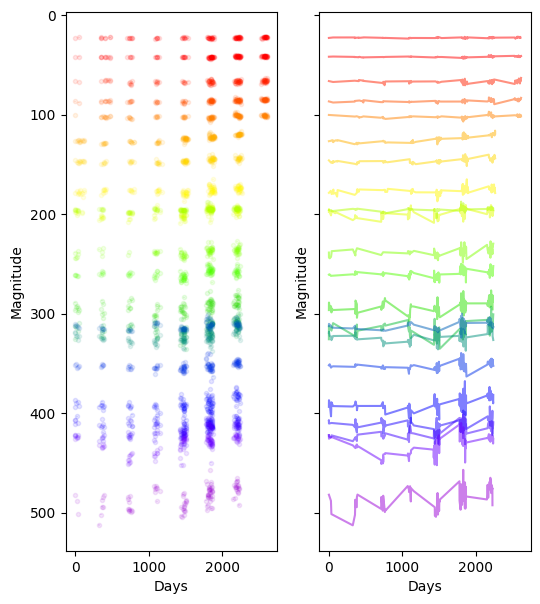

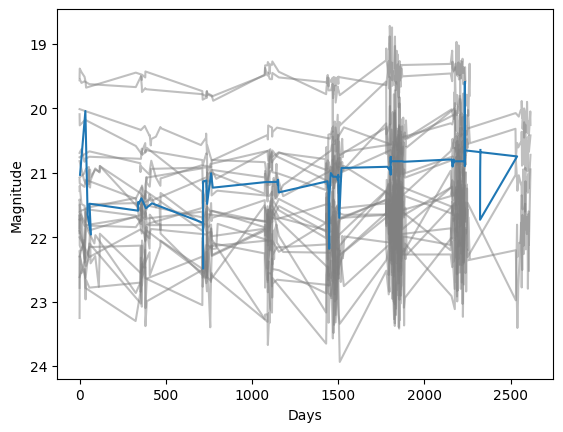

In [19]:
#Plotting the average of the clusters 
Averaging_Clusters(1,cluster_map,light_curves[0],dba = True)

For the next function, you can get distributions of just one property from z, variability function, luminosity, and mass. Except for the luminosity, all the others need the redshift associated with each ID. Please prepare a redshifts list as a csv file matching each id (in an int format) to its corresponding redshift. Without it, only the variability function can be plotted

In [21]:
redshifts_map = pd.read_csv('Redshift_Map.csv')

In [22]:
redshifts_map

ID         z
0    1384177  1.027752
1    1384184  0.386056
2    1384186  1.475959
3    1384188  0.865602
4    1384192  0.487227
..       ...       ...
979  1467843  2.580724
980  1467876  1.765449
981  1467897  1.657999
982  1467921  1.505258
983  1467993  1.115302

[984 rows x 2 columns]

In [23]:
redshifts_map.ID

0      1384177
1      1384184
2      1384186
3      1384188
4      1384192
        ...   
979    1467843
980    1467876
981    1467897
982    1467921
983    1467993
Name: ID, Length: 984, dtype: int64

<Figure size 640x480 with 0 Axes>

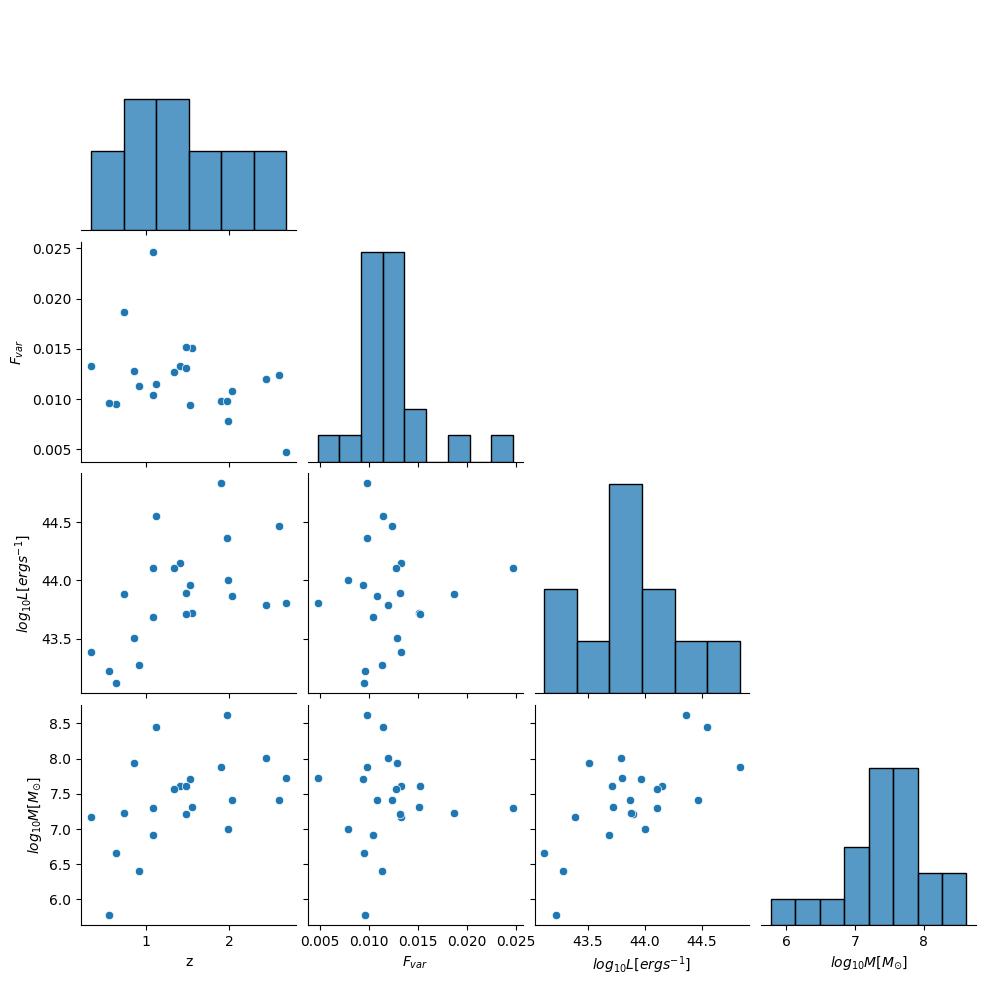

In [25]:
Cluster_Properties(cluster_map,1,light_curves[0],the_property='all',redshifts_map = redshifts_map)

The Structure function is the measure of variability in the light curve. We also present the modified structure functions S+ and S- (which measure the variability of points that are only increasing and decreasing respectively). (See https://academic.oup.com/mnras/article/329/1/76/1113051)

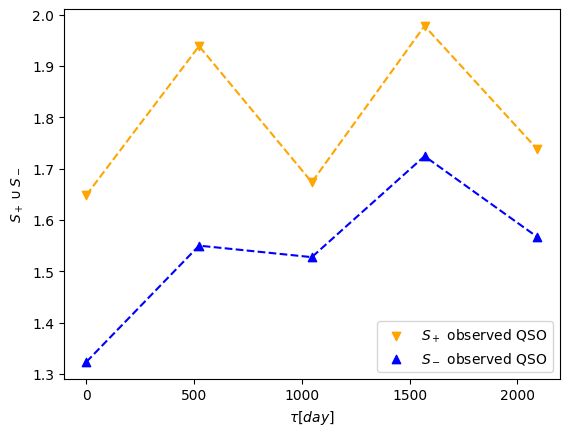

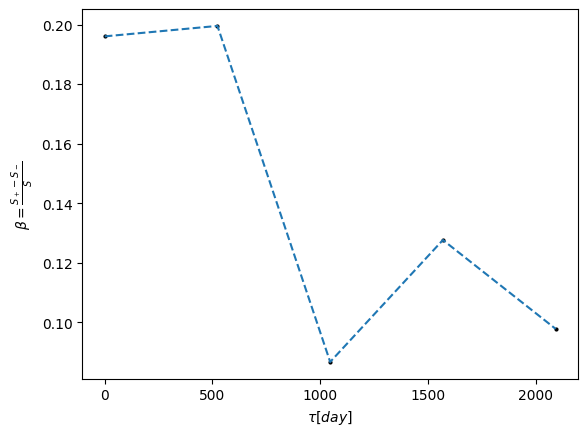

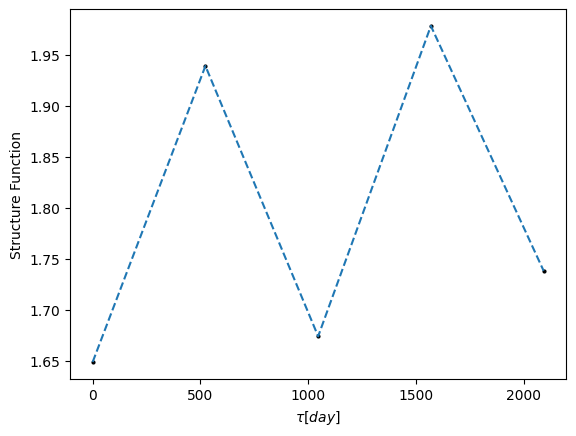

In [26]:
Structure_Function(cluster_map,1,light_curves[0],5)

## Visualizations for All the Clusters

In [28]:
#Plotting the average real (i.e not scaled or padded) light curves for each cluster
Plot_All_Clusters(cluster_map,light_curves[0])

Plotting Averaged Clusters: 100%|██████████████████████████████████████████████████████| 36/36 [00:50<00:00,  1.39s/it]


In [29]:
#Plotting the properties distribution for each cluster
Cluster_Properties_Comparison(cluster_map,light_curves[0],redshifts_map)

C:\Users\rajua\3rd Sem Masters\Thesis Research\Final Submission Script + Notebooks\Clustering_with_SOM.py:1528: RuntimeWarning:

invalid value encountered in sqrt

Plotting Fvar Distribution:   0%|                                                                | 0/6 [00:00<?, ?it/s]C:\Users\rajua\3rd Sem Masters\Thesis Research\Final Submission Script + Notebooks\Clustering_with_SOM.py:1528: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\rajua\3rd Sem Masters\Thesis Research\Final Submission Script + Notebooks\Clustering_with_SOM.py:1528: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\rajua\3rd Sem Masters\Thesis Research\Final Submission Script + Notebooks\Clustering_with_SOM.py:1528: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\rajua\3rd Sem Masters\Thesis Research\Final Submission Script + Notebooks\Clustering_with_SOM.py:1528: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\rajua\3rd Sem Masters\Thesis Research\Final Submissi